# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA   
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)
azdias.head()


(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Check the structure of the data after it's loadeds

print(feat_info.shape)
feat_info.head()

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

naturally_missing = azdias.isnull().sum().sum()

print('Number of naturally missing values in dataset: {}'.format(naturally_missing))


Number of naturally missing values in dataset: 4896838


In [7]:
# Identify missing or unknown data values and convert them to NaNs.

#feat_info.describe()

for i in range(len(feat_info)):
    missing = feat_info.iloc[i]['missing_or_unknown']
    missing = missing.strip('[')
    missing = missing.strip(']')
    missing = missing.split(sep=',')
    missing = [int(num) if (num!='X' and num!='XX' and num!='') else num for num in missing]
    if missing != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing}, np.nan)

missing_after_correction = azdias.isnull().sum().sum()
print('Number of values missing in dataset after correction: {}'.format(missing_after_correction))


Number of values missing in dataset after correction: 8373929


In [8]:
print('Increase in missing values due to correction is: {}'.format(missing_after_correction-naturally_missing))


Increase in missing values due to correction is: 3477091


In [9]:
print(azdias.shape)

azdias.describe()


(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_values_per_col = (azdias.isnull().sum()/len(azdias))*100
missing_values_per_col = missing_values_per_col.sort_values(ascending=False)

print(missing_values_per_col)


TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

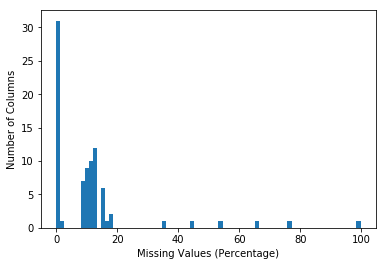

In [11]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(missing_values_per_col,bins=75)
plt.ylabel('Number of Columns')
plt.xlabel('Missing Values (Percentage)')
plt.show()

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

greater_than_20_pct_missing = missing_values_per_col[missing_values_per_col>20]

drop_columns = greater_than_20_pct_missing.index.tolist()

print('Six columns with greater than 20% of data missing will be dropped: {}'.format(drop_columns))

azdias = azdias.drop(drop_columns, axis=1)

azdias.shape

Six columns with greater than 20% of data missing will be dropped: ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Our dataset does contain many missing values. Nearly 5 million values were naturally missing in the dataset, and nearly 3.5 million values that were missing or unknown had to be manually corrected.

However, many of the dataset's missing values appeared to be constrained to only certain columns. The majority of columns only had 0-20% of their values missing, while a select few columns had up to 30%, or 40%, or even up to 99% of their values missing. 

Thus, six columns containing greater than 20% of missing values were dropped. These columns included: TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, and ALTER_HH.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [13]:
# How much data is missing in each row of the dataset?

missing_rows = azdias.isnull().sum(axis=1)

missing_rows.describe()


count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

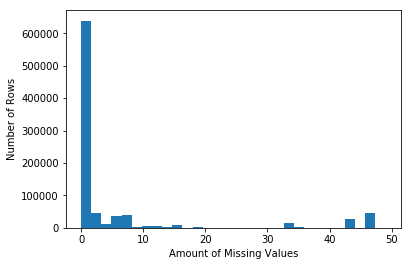

In [14]:
# Visualizing data missing in each row of the dataset

plt.hist(missing_rows, bins=30)
plt.xlabel('Amount of Missing Values')
plt.ylabel('Number of Rows')
plt.show()

In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Divide the data based on rows with more or less than 30 missing values

azdias_missing_lessthan30 = azdias[azdias.isnull().sum(axis=1) < 30].reset_index(drop=True)

azdias_missing_greater30 = azdias[azdias.isnull().sum(axis=1) >= 30].reset_index(drop=True)


In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_comparison(column):
    figure = plt.figure(figsize=(15,4))
    plot1 = figure.add_subplot(121)
    plot1.title.set_text('Data with lots of missing values')
    sns.countplot(azdias_missing_greater30[column])
    plot2 = figure.add_subplot(122)
    plot2.title.set_text('Data with few missing values')
    sns.countplot(azdias_missing_lessthan30[column]);
    plt.show()


In [17]:
azdias.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ',
       'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO

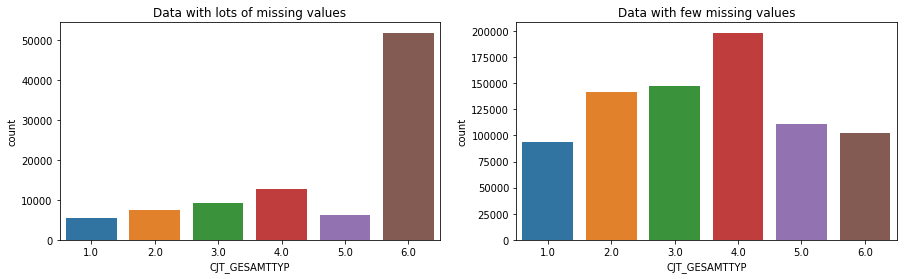

In [18]:
plot_comparison('CJT_GESAMTTYP')

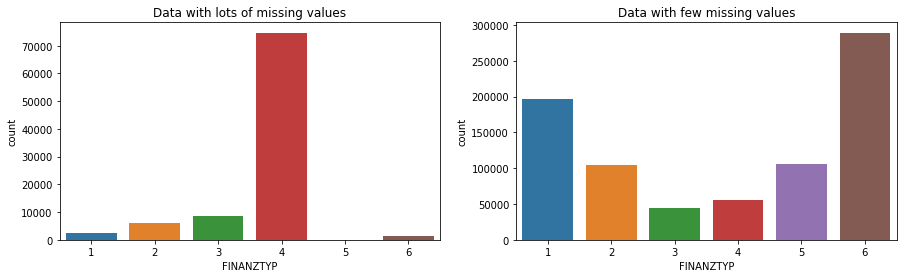

In [19]:
plot_comparison('FINANZTYP')

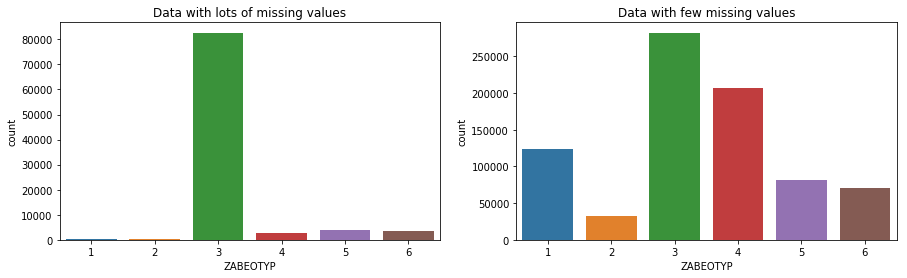

In [20]:
plot_comparison('ZABEOTYP')

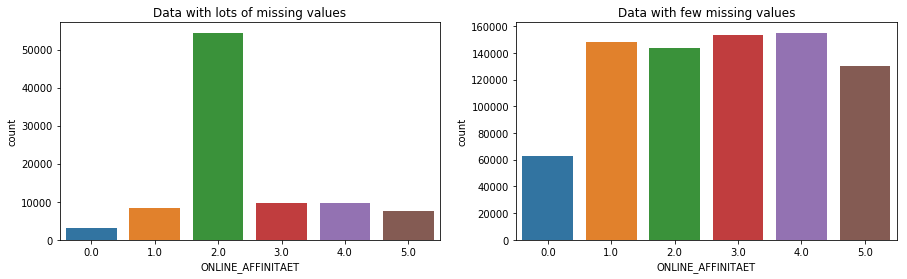

In [21]:
plot_comparison('ONLINE_AFFINITAET')

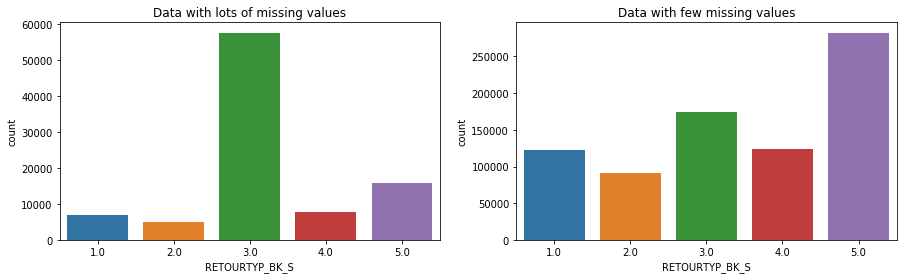

In [22]:
plot_comparison('RETOURTYP_BK_S')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Yes, data with lots of missing values (more than 30 missing values per row of data) are qualitatively different from data with few missing values (less thsn 30 missing values per row of data). Based on a brief exploration of a few variables, we see that the distributions do differ considerably those for data with many missing values compared to data with few missing values. Thus, we will drop rows of data with many missing values.

In [23]:
# Drop rows of data with many missing values

rows_all = azdias.shape[0]

azdias = azdias_missing_lessthan30

rows_after_removing_missing = azdias.shape[0]

print('Rows containg greater than 30 missing values will be dropped. {} rows will be dropped.'.format(rows_all-rows_after_removing_missing))


Rows containg greater than 30 missing values will be dropped. 93160 rows will be dropped.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?

feat_info.head()

feat_info['type'].value_counts()


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_columns = feat_info.loc[feat_info['type']=='categorical','attribute'].values

# Remove columns that have already been dropped in the dataset
categorical_columns = [x for x in categorical_columns if x not in drop_columns]


In [26]:
# Create list of binary and multi-level categorical variables

binary_columns = []
multi_level_columns = []
for i in categorical_columns:
    if azdias[i].nunique() <= 2:
        binary_columns.append(i)
    else:
        multi_level_columns.append(i)    

In [27]:
# Assess binary columns

print(binary_columns)

for i in binary_columns:
    print(azdias[i].value_counts())

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
2    416177
1    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    394238
1.0    367102
Name: VERS_TYP, dtype: int64
W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64


In [28]:
# Assess mulit-level columns

print(multi_level_columns)

for i in multi_level_columns:
    print(azdias[i].value_counts())

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
4.0    198295
3.0    147220
2.0    141269
5.0    111114
6.0    102107
1.0     93311
Name: CJT_GESAMTTYP, dtype: int64
6    289061
1    197171
5    106332
2    104773
4     55922
3     44802
Name: FINANZTYP, dtype: int64
12.0    130261
10.0    102831
8.0      83030
11.0     75103
5.0      70501
4.0      60422
9.0      57131
3.0      53101
1.0      50659
2.0      43857
7.0      40681
6.0      25739
Name: GFK_URLAUBERTYP, dtype: int64
1.0     402556
10.0    128974
2.0      98555
11.0     48746
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    402556
5.0    188172
2.0     98555
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206853
9.0     136353
10.0

In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias = pd.get_dummies(azdias, columns=multi_level_columns)


In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
azdias['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)


In [31]:
# Check encodings

for i in binary_columns:
    print(azdias[i].value_counts())

1    416177
0    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
1.0    394238
0.0    367102
Name: VERS_TYP, dtype: int64
1    629520
0    168541
Name: OST_WEST_KZ, dtype: int64


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

No categorical features were dropped as all could be re-encoded in a straightforward manner. Multilevel categorical features were re-encoded using the pandas get_dummies function. Binary categorical features were re-encoded using values of 1 and 0.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [32]:
# Select only mixed features

mixed_columns = feat_info.loc[feat_info['type']=='mixed','attribute'].values

# Remove columns that have already been dropped in the dataset
mixed_columns = [x for x in mixed_columns if x not in drop_columns]

print(mixed_columns)


['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [33]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Create map for generation
gen_map = {0: [1, 2], 
            1: [3, 4], 
            2: [5, 6, 7], 
            3: [8, 9], 
            4: [10, 11, 12, 13], 
            5: [14, 15]}

def generation_map(x):
    try:
        for key, array in gen_map.items():
            if x in array:
                return key
    except ValueError:
        return np.nan

# Create generation column based on map
azdias['PRAEGENDE_JUGENDJAHRE_generation'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(generation_map)

print(azdias['PRAEGENDE_JUGENDJAHRE_generation'].head())

print('Number of null values: {}'.format(azdias['PRAEGENDE_JUGENDJAHRE_generation'].isnull().sum()))

0    5.0
1    5.0
2    3.0
3    3.0
4    1.0
Name: PRAEGENDE_JUGENDJAHRE_generation, dtype: float64
Number of null values: 28755


In [34]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Create map for movement
main_map = [1, 3, 5, 8, 10, 12, 14]

def movement_map(x):
    try:
        if x in main_map:
            return 0
        else:
            return 1
    except ValueError:
        return np.nan

# Create movement column based on map
azdias['PRAEGENDE_JUGENDJAHRE_movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(movement_map)

print(azdias['PRAEGENDE_JUGENDJAHRE_movement'].head())

print('Number of null values: {}'.format(azdias['PRAEGENDE_JUGENDJAHRE_movement'].isnull().sum()))

0    0
1    1
2    0
3    0
4    0
Name: PRAEGENDE_JUGENDJAHRE_movement, dtype: int64
Number of null values: 0


In [35]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Create map for wealth

def wealth_map(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])

azdias['CAMEO_INTL_2015_wealth'] = azdias['CAMEO_INTL_2015'].apply(wealth_map)

print(azdias['CAMEO_INTL_2015_wealth'].head())

print('Number of null values: {}'.format(azdias['CAMEO_INTL_2015_wealth'].isnull().sum()))

0    5.0
1    2.0
2    1.0
3    4.0
4    5.0
Name: CAMEO_INTL_2015_wealth, dtype: float64
Number of null values: 6198


In [36]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Create map for lifestage

def lifestage_map(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])

azdias['CAMEO_INTL_2015_lifestage'] = azdias['CAMEO_INTL_2015'].apply(lifestage_map)
    
print(azdias['CAMEO_INTL_2015_lifestage'].head())

print('Number of null values: {}'.format(azdias['CAMEO_INTL_2015_lifestage'].isnull().sum()))


0    1.0
1    4.0
2    2.0
3    3.0
4    4.0
Name: CAMEO_INTL_2015_lifestage, dtype: float64
Number of null values: 6198


In [37]:
azdias[['CAMEO_INTL_2015','CAMEO_INTL_2015_wealth','CAMEO_INTL_2015_lifestage']].head()

,CAMEO_INTL_2015,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,51,5.0,1.0
1,24,2.0,4.0
2,12,1.0,2.0
3,43,4.0,3.0
4,54,5.0,4.0


In [38]:
# Drop original PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 columns

azdias.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Regarding mixed-value features, the columns were mapped using dictionaries in Python. For PRAEGENDE_JUGENDJAHRE, only the generation and movement features were kept, and the original column was then removed. For CAMEO_INTL_2015, only the wealth and lifestage features were kept, and the original columns were then removed. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias.describe()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_generation,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
count,795258.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,761340.000000,...,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,769306.000000,798061.000000,791863.000000,791863.00000
mean,2.795412,0.521485,3.058917,2.716047,3.432892,2.840955,2.658348,3.114102,0.219563,2.199015,...,0.022023,0.025740,0.034679,0.031310,0.035828,0.007993,3.332006,0.255594,3.262107,2.87303
std,1.018409,0.499538,1.377577,1.485090,1.376866,1.472782,1.399530,1.408109,0.413951,0.755170,...,0.146760,0.158358,0.182966,0.174153,0.185861,0.089046,1.457412,0.436195,1.464495,1.48477
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000
25%,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,1.00000
50%,3.000000,1.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,4.000000,3.00000
75%,4.000000,1.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,5.000000,4.00000
max,4.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,5.000000,5.00000


In [40]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

print(azdias.info())

azdias.head(n=10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798061 entries, 0 to 798060
Columns: 196 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_lifestage
dtypes: float64(44), int64(24), uint8(128)
memory usage: 511.5 MB
None


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_generation,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,5.0,0,5.0,1.0
1,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,5.0,1,2.0,4.0
2,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,3.0,0,1.0,2.0
3,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,3.0,0,4.0,3.0
4,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1.0,0,5.0,4.0
5,2.0,1,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,4.0,0,2.0,2.0
6,1.0,0,3,3,4,1,3,2,0,1.0,...,0,0,0,0,0,0,3.0,0,1.0,4.0
7,3.0,0,4,4,2,4,2,2,1,3.0,...,0,0,0,0,0,0,4.0,1,1.0,3.0
8,3.0,1,2,4,2,3,5,4,1,2.0,...,0,0,0,0,0,0,5.0,1,1.0,5.0
9,3.0,1,2,2,5,3,1,5,0,2.0,...,0,0,0,0,1,0,1.0,0,5.0,1.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [41]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for i in range(len(feat_info)):
        missing = feat_info.iloc[i]['missing_or_unknown']
        missing = missing.strip('[')
        missing = missing.strip(']')
        missing = missing.split(sep=',')
        missing = [int(num) if (num!='X' and num!='XX' and num!='') else num for num in missing]
        if missing != ['']:
            df = df.replace({feat_info.iloc[i]['attribute']: missing}, np.nan)

    # remove selected columns and rows, ...

    df = df.drop(drop_columns, axis=1)
    
    missing_rows = df.isnull().sum(axis=1)
    missing_rows_lessthan30 = missing_rows[missing_rows < 30]
    
    df = df[df.isnull().sum(axis=1) < 30].reset_index(drop=True)
    
    df = pd.get_dummies(df, columns=multi_level_columns)
    
    df['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
    df['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
    df['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    
    # select, re-encode, and engineer column values.
    
    df['PRAEGENDE_JUGENDJAHRE_generation'] = df['PRAEGENDE_JUGENDJAHRE'].apply(generation_map)
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(movement_map)

    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(wealth_map)
    df['CAMEO_INTL_2015_lifestage'] = df['CAMEO_INTL_2015'].apply(lifestage_map)
    
    df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [42]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# print(azdias.isnull().sum().sum())

imputer = Imputer()
azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)


In [43]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()

azdias = pd.DataFrame(scaler.fit_transform(azdias), columns = azdias.columns)


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Missing values in each column were imputed using sklearn's Imputer package, which replaces the missing values of a column with the mean of that column. Data was also standardized using the sklearn's StandardScaler package, such that all data would be placed on the same stadardized scale for additional analyses.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
# Apply PCA to the data.

pca = PCA()
pca_azdias = pca.fit_transform(azdias)


In [45]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    """
    Creates scree plot for pca analysis
    
    INPUT: PCA that has been instantiated in sklearn
    OUTPUT: Scree plot
    """
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_xlabel('Component')
    ax.set_ylabel('Varance Explained Percentage')
    plt.title('Scree Plot Showing Percent Variance Explained by Principal Component')


Number of components accounting for 60% of variance: 47
Number of components accounting for 80% of variance: 86


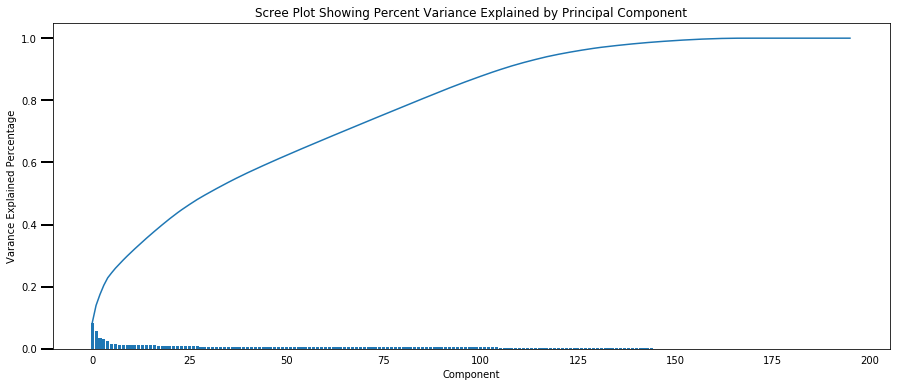

In [46]:
# Investigate the variance accounted for by each principal component.

scree_plot(pca)

n_components_60 = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.6)[0]+1)

n_components_80 = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.8)[0]+1)

print('Number of components accounting for 60% of variance: {}'.format(n_components_60))

print('Number of components accounting for 80% of variance: {}'.format(n_components_80))

In [47]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Will select for 47 components that account for 60% of variance

pca = PCA(n_components=47)
pca_azdias = pca.fit_transform(azdias)


In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.

print('Final PCA percent of variance explained is: {}'.format(round(pca.explained_variance_ratio_.sum(),3)))

Final PCA percent of variance explained is: 0.595


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Principal components analysis was first applied to the final transformed azdias dataset. A scree plot showed that 47 components accounted for 60% of the variance in the data, and so these 47 components were retained for the final PCA analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [49]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weight_mapping(df, pca, component_number):
    """
    Creates weight mapping for components of PCA analysis
    
    INPUT: df: Dataframe of data
           pca: PCA that has been instantiated in sklearn
           component_number: Component number to examine weights of
    OUTPUT: Returns table and weight mapping plot of the principal component specified
    """
    table=pd.DataFrame(pca.components_[component_number-1])
    table.index=list(df.columns)
    colname='Component'+' '+str(component_number)
    table.columns=[colname]
    table=table.sort_values(by=[colname], ascending=False)
    print(table.head(n=10), table.tail(10))
    
    mapping = pd.DataFrame(np.round(pca.components_, 5), columns = df.keys()).iloc[component_number-1]
    mapping = mapping.sort_values(ascending=False)
    mapping = pd.concat([mapping.head(10), mapping.tail(10)])
    mapping.plot(kind='bar', title='Component'+' '+str(component_number))
    plt.show()


                        Component 1
LP_STATUS_GROB_1.0         0.188885
CAMEO_INTL_2015_wealth     0.180030
HH_EINKOMMEN_SCORE         0.179927
PLZ8_ANTG3                 0.179824
PLZ8_ANTG4                 0.174587
PLZ8_BAUMAX                0.170431
ORTSGR_KLS9                0.153816
EWDICHTE                   0.152204
FINANZ_HAUSBAUER           0.146947
LP_STATUS_FEIN_1.0         0.127171                      Component 1
INNENSTADT             -0.126256
LP_LEBENSPHASE_GROB    -0.128297
PLZ8_GBZ               -0.132111
KONSUMNAEHE            -0.135086
LP_LEBENSPHASE_FEIN    -0.141565
KBA05_GBZ              -0.177098
FINANZ_MINIMALIST      -0.179231
PLZ8_ANTG1             -0.180379
KBA05_ANTG1            -0.186420
MOBI_REGIO             -0.199557


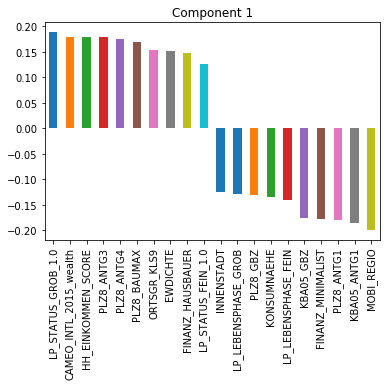

In [50]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pca_weight_mapping(azdias, pca, 1)

                      Component 2
ALTERSKATEGORIE_GROB     0.237376
FINANZ_VORSORGER         0.223430
ZABEOTYP_3               0.199157
SEMIO_ERL                0.180866
SEMIO_LUST               0.166025
RETOURTYP_BK_S           0.155369
W_KEIT_KIND_HH           0.127837
CJT_GESAMTTYP_2.0        0.110956
FINANZ_MINIMALIST        0.101875
FINANZTYP_5              0.097812                                   Component 2
ONLINE_AFFINITAET                   -0.158906
SEMIO_KULT                          -0.165472
SEMIO_RAT                           -0.172894
FINANZ_ANLEGER                      -0.207391
SEMIO_PFLICHT                       -0.209817
SEMIO_TRADV                         -0.210491
FINANZ_UNAUFFAELLIGER               -0.217015
SEMIO_REL                           -0.217709
FINANZ_SPARER                       -0.234043
PRAEGENDE_JUGENDJAHRE_generation    -0.241639


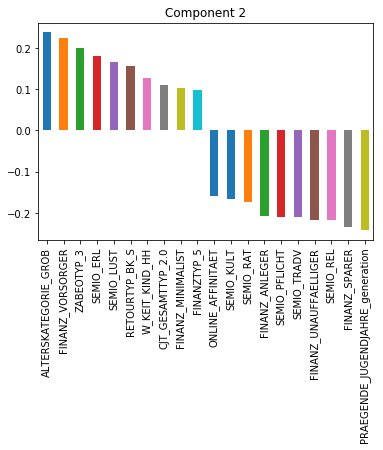

In [51]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_mapping(azdias, pca, 2)

                   Component 3
SEMIO_VERT            0.317025
SEMIO_FAM             0.257934
SEMIO_SOZ             0.255334
SEMIO_KULT            0.249345
FINANZTYP_5           0.135711
FINANZ_MINIMALIST     0.132090
SHOPPER_TYP_0.0       0.121938
ZABEOTYP_1            0.121265
SEMIO_REL             0.112450
SEMIO_MAT             0.087917                     Component 3
LP_STATUS_FEIN_2.0    -0.079282
SHOPPER_TYP_2.0       -0.093225
FINANZTYP_1           -0.100787
SEMIO_RAT             -0.152670
FINANZ_ANLEGER        -0.153577
SEMIO_ERL             -0.206779
SEMIO_KRIT            -0.266785
SEMIO_DOM             -0.279043
SEMIO_KAEM            -0.311213
ANREDE_KZ             -0.342052


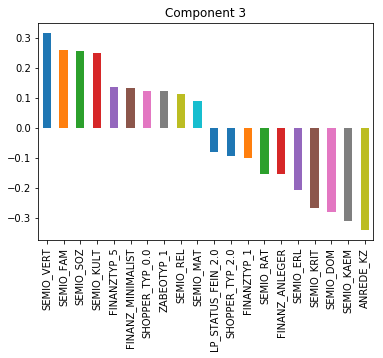

In [52]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_mapping(azdias, pca, 3)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


### 1) First principal component:
 - Has a positive association with:
   - LP_STATUS_GROB_1.0
   - CAMEO_INTL_2015_wealth
   - HH_EINKOMMEN_SCORE
   - PLZ8_ANTG3
 - Has a negative association with: 
   - MOBI_REGIO
   - KBA05_ANTG1
   - PLZ8_ANTIG1
   - KONSUMNAEHE

The first principal component appears to be related to variables such as income, wealth, and movement generally.


### 2) Second principal component:
 - Has a positive association with:
   - ALTERSKATEGORIE_GROB
   - FINANZ_VORSORGER
   - ZABEOTYP_3
   - SEMIO_ERL
 - Has a negative association with: 
   - PRAEGENDE_JUGENDJAHRE_generation
   - FINANZ_SPARER
   - SEMIO_REL
   - FINANZ_ANLEGER

The second principal component appears to be related to variables related to older individuals, financially prepared individuals, and an individual's decade of movement.

### 3) Third principal component:
 - Has a positive association with:
   - SEMIO_VERT
   - SEMIO_FAM
   - SEMIO_SOZ
   - SEMIO_KULT
 - Has a negative association with: 
   - LP_STATUS_FEIN_2.0
   - SHOPPER_TYP_2.0
   - FINANZTYP_1
   - SEMIO_RAT 

The third principal component appears to be related to personality variables such as those who are not socially-minded, not dreamful, and not family-minded individuals, as well as gender.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [53]:
# Over a number of different cluster counts...
start_time = time.time()
number_of_clusters = np.arange(2,10)
kmeans_cluster_dist = []

# run k-means clustering on the data and...
for i in number_of_clusters:
    kmeans = KMeans(i)
    kmeans.fit(pca_azdias)
    
    # compute the average within-cluster distances.
    kmeans_score = kmeans.score(pca_azdias)
    print("For {} clusters the within-cluster distance is {}.".format(i, round(kmeans_score,2)))
    kmeans_cluster_dist.append(kmeans_score)
    
end_time = time.time()
print("Run time is {} mins".format(round((end_time-start_time)/60),2))

For 2 clusters the within-cluster distance is -83225831.08.
For 3 clusters the within-cluster distance is -78795860.2.
For 4 clusters the within-cluster distance is -75837531.81.
For 5 clusters the within-cluster distance is -73413603.45.
For 6 clusters the within-cluster distance is -71934252.92.
For 7 clusters the within-cluster distance is -70553140.91.
For 8 clusters the within-cluster distance is -69202064.64.
For 9 clusters the within-cluster distance is -68208354.71.
Run time is 14 mins


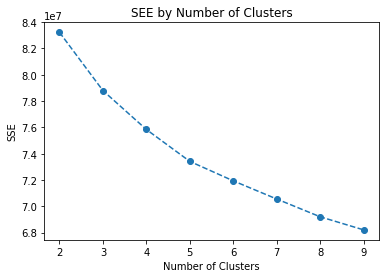

In [54]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(number_of_clusters, np.abs(kmeans_cluster_dist), linestyle='--', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('SEE by Number of Clusters')
plt.show()


In [55]:
# Over a number of different cluster counts...
start_time = time.time()
number_of_clusters = [15, 20, 25]
kmeans_cluster_dist = []

# run k-means clustering on the data and...
for i in number_of_clusters:
    kmeans = KMeans(i)
    kmeans.fit(pca_azdias)
    
    # compute the average within-cluster distances.
    kmeans_score = kmeans.score(pca_azdias)
    print("For {} clusters the within-cluster distance is {}.".format(i, round(kmeans_score,2)))
    kmeans_cluster_dist.append(kmeans_score)
    
end_time = time.time()
print("Run time is {} mins".format(round((end_time-start_time)/60),2))

For 15 clusters the within-cluster distance is -63406316.43.
For 20 clusters the within-cluster distance is -60681500.68.
For 25 clusters the within-cluster distance is -58642807.55.
Run time is 20 mins


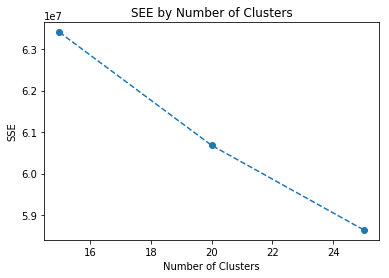

In [56]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(number_of_clusters, np.abs(kmeans_cluster_dist), linestyle='--', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('SEE by Number of Clusters')
plt.show()


In [57]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
start_time = time.time()

kmeans = KMeans(n_clusters=20)
kmeans_azdias = kmeans.fit(pca_azdias)
kmeans_azdias_labels = kmeans_azdias.predict(pca_azdias)
   
end_time = time.time()
print("Run time is {} mins".format(round((end_time-start_time)/60),2))

Run time is 7 mins


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Due to lengthy computation time, kmeans models were created with 2-9, 15, 20, and 25 centers. Plots were then created of SSE versus the number of clusters. As data started to level off after 20 clusters, 20 was chosen as the number of clusters to segment the population.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [58]:
# Load in the customer demographics data.

customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [59]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Data cleaning function created in previous step
customers = clean_data(customers)

# Impute missing values using the mean value in each column
customers = pd.DataFrame(imputer.fit_transform(customers), columns = customers.columns)


In [60]:
# View processed and tranformed data

customers.head(n=15)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_generation,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,4.0,0.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0
1,4.0,1.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,4.0
2,4.0,0.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0
3,3.0,0.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,1.0
4,3.0,0.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,4.0
5,4.0,0.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0
6,4.0,0.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0
7,4.0,1.0,2.0,2.0,5.0,1.0,1.0,5.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,5.0
8,3.0,0.0,5.0,2.0,4.0,1.0,3.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,5.0
9,4.0,0.0,5.0,1.0,5.0,1.0,3.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0


In [61]:
# Fix differing number of columns between customer and population data

# print(azdias.shape)
# print(customers.shape)

missing_col = set(azdias.columns) - set(customers.columns)

print(missing_col)

# One column is missing from customer data, add missing column with dummy values

customers['GEBAEUDETYP_5.0'] = 0

print(customers.shape)

{'GEBAEUDETYP_5.0'}
(141725, 196)


In [62]:
# Standardize data

customers = pd.DataFrame(scaler.fit_transform(customers), columns = customers.columns)


In [63]:
# Apply PCA and kmeans clustering on the customer demographics data

start_time = time.time()

pca_customers = pca.transform(customers)
kmeans_customers = kmeans.predict(pca_customers)

end_time = time.time()
print("Run time is {} mins".format(round((end_time-start_time)/60),2))


Run time is 0 mins


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [64]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

prop_pop = []
prop_cust = []
cluster_number = np.arange(20)+1

for i in cluster_number:
    prop_pop.append((kmeans_azdias_labels==i).sum()/len(kmeans_azdias_labels))
    prop_cust.append((kmeans_customers==i).sum()/len(kmeans_customers))

prop = pd.DataFrame({'Cluster Number': cluster_number,
                     'Population Proportion': prop_pop,
                     'Customer Proportion': prop_cust})


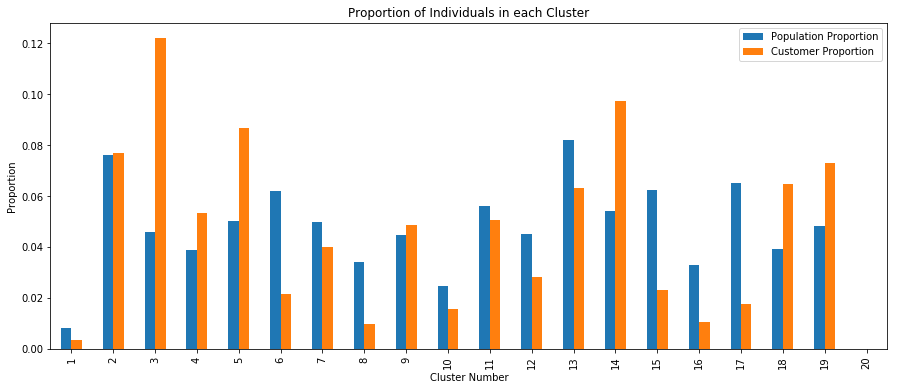

In [65]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

prop.plot(x = 'Cluster Number', y = ['Population Proportion','Customer Proportion'], kind='bar', figsize=(15,6))
plt.ylabel('Proportion')
plt.title('Proportion of Individuals in each Cluster')
plt.show()

In [106]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

columns_to_examine = {'ALTERSKATEGORIE_GROB': ['Age'], #larger numbers are older
                        'ANREDE_KZ': ['Gender'], #male is 1, female is 2
                        'HH_EINKOMMEN_SCORE': ['HH Income'], #larger numbers indicate lower income
                        'CAMEO_INTL_2015_wealth': ['Wealth'], #lower numbers wealthier
                        'MOBI_REGIO': ['Movement']} # higher numbers indicate lower movement


def demographics_comparison(cluster_number, columns_to_compare):
    """
    Creates plots for comparing demographics between customers and the general population
    
    INPUT: cluster_number: Number of cluster to examine
           columns_to_compare: Column names of demographic variables to compare
    OUTPUT: Returns plots and summary statistics comparing demographics between customers and the general population
    """
    data_pop = scaler.inverse_transform(pca.inverse_transform(pca_azdias[np.where(kmeans_azdias_labels==cluster_number)]))
    data_pop = pd.DataFrame(data=data_pop,
                  index=np.array(range(0, data_pop.shape[0])),
                  columns=azdias.columns)

    data_pop_cols = pd.DataFrame(data_pop[columns_to_compare])

    data_cust = scaler.inverse_transform(pca.inverse_transform(pca_customers[np.where(kmeans_customers==cluster_number)]))
    data_cust = pd.DataFrame(data=data_cust,
                  index=np.array(range(0, data_cust.shape[0])),
                  columns=azdias.columns)

    data_cust_cols = pd.DataFrame(data_cust[columns_to_compare])

    for i in columns_to_compare:
        plt.hist(data_pop_cols[i])
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.title('Population'+' '+i)
        plt.show()
        print(data_pop_cols[i].describe())

        plt.hist(data_cust_cols[i])
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.title('Customer'+' '+i)
        plt.show()
        print(data_cust_cols[i].describe())
        

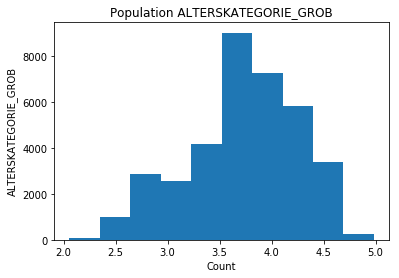

count    36531.000000
mean         3.727776
std          0.530296
min          2.055939
25%          3.449939
50%          3.764091
75%          4.123297
max          4.982853
Name: ALTERSKATEGORIE_GROB, dtype: float64


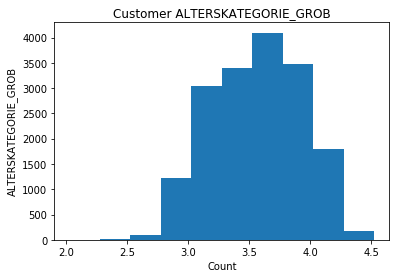

count    17281.000000
mean         3.561092
std          0.365238
min          2.026994
25%          3.270745
50%          3.579390
75%          3.843731
max          4.520743
Name: ALTERSKATEGORIE_GROB, dtype: float64


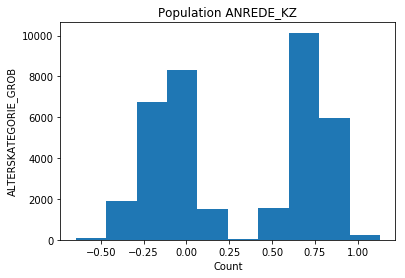

count    36531.000000
mean         0.301653
std          0.440018
min         -0.645652
25%         -0.106854
50%          0.142968
75%          0.731268
max          1.129794
Name: ANREDE_KZ, dtype: float64


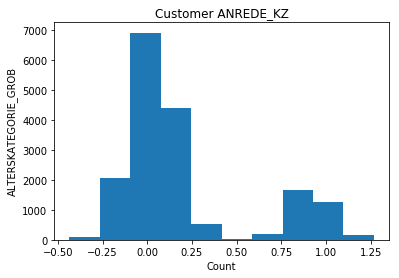

count    17281.000000
mean         0.197693
std          0.364944
min         -0.435352
25%         -0.033442
50%          0.066572
75%          0.207967
max          1.266918
Name: ANREDE_KZ, dtype: float64


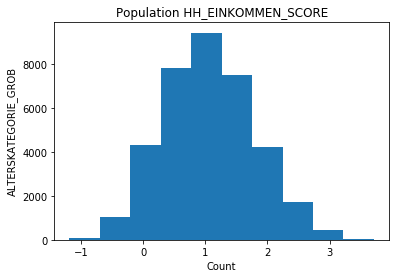

count    36531.000000
mean         1.063641
std          0.725530
min         -1.185380
25%          0.543257
50%          1.031890
75%          1.547490
max          3.712716
Name: HH_EINKOMMEN_SCORE, dtype: float64


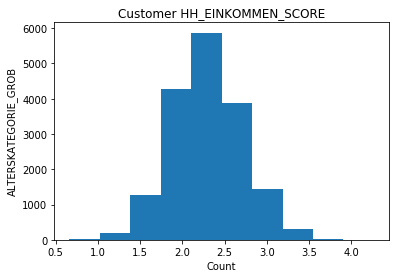

count    17281.000000
mean         2.294338
std          0.413307
min          0.664940
25%          2.013541
50%          2.278540
75%          2.562250
max          4.266993
Name: HH_EINKOMMEN_SCORE, dtype: float64


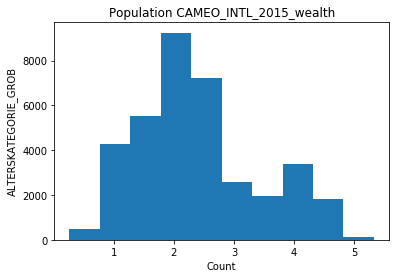

count    36531.000000
mean         2.398518
std          1.005941
min          0.265084
25%          1.687913
50%          2.233940
75%          2.903332
max          5.324154
Name: CAMEO_INTL_2015_wealth, dtype: float64


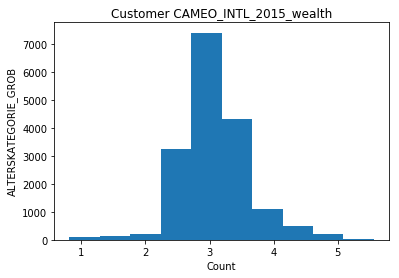

count    17281.000000
mean         3.072231
std          0.527875
min          0.815360
25%          2.758059
50%          3.028005
75%          3.330721
max          5.563062
Name: CAMEO_INTL_2015_wealth, dtype: float64


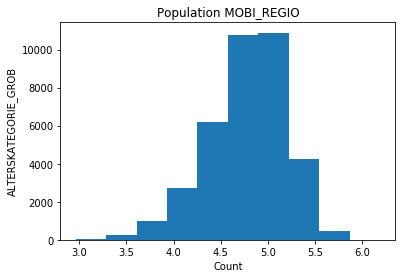

count    36531.000000
mean         4.783770
std          0.410415
min          2.960646
25%          4.536064
50%          4.830525
75%          5.075500
max          6.192655
Name: MOBI_REGIO, dtype: float64


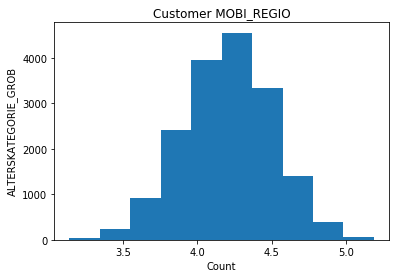

count    17281.000000
mean         4.205294
std          0.299145
min          3.138989
25%          4.002281
50%          4.210213
75%          4.412577
max          5.188536
Name: MOBI_REGIO, dtype: float64


In [109]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Will examine cluster 3

columns = ['ALTERSKATEGORIE_GROB','ANREDE_KZ','HH_EINKOMMEN_SCORE','CAMEO_INTL_2015_wealth','MOBI_REGIO']
k = 3

demographics_comparison(k, columns)

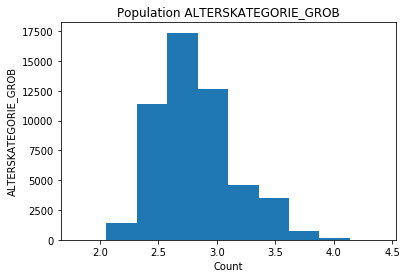

count    51866.000000
mean         2.815899
std          0.327394
min          1.795526
25%          2.578618
50%          2.777098
75%          2.980773
max          4.398025
Name: ALTERSKATEGORIE_GROB, dtype: float64


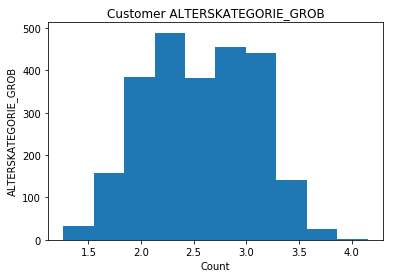

count    2510.000000
mean        2.564308
std         0.507181
min         1.259771
25%         2.157513
50%         2.560206
75%         2.984881
max         4.152546
Name: ALTERSKATEGORIE_GROB, dtype: float64


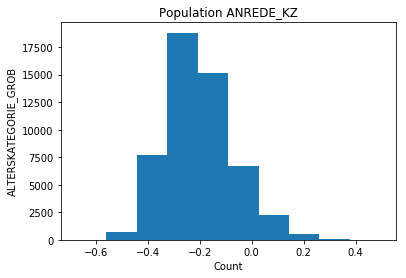

count    51866.000000
mean        -0.202229
std          0.128647
min         -0.675232
25%         -0.288304
50%         -0.214984
75%         -0.126937
max          0.495029
Name: ANREDE_KZ, dtype: float64


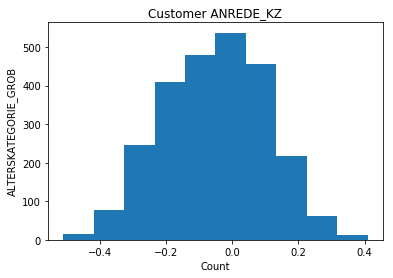

count    2510.000000
mean       -0.051675
std         0.155567
min        -0.510241
25%        -0.169588
50%        -0.044095
75%         0.062914
max         0.409253
Name: ANREDE_KZ, dtype: float64


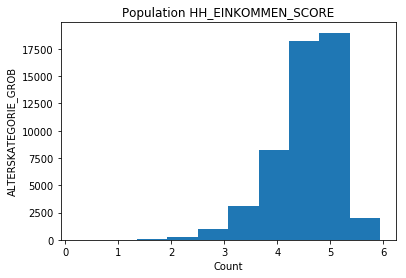

count    51866.000000
mean         4.555172
std          0.608806
min          0.199018
25%          4.235890
50%          4.677071
75%          4.983268
max          5.945174
Name: HH_EINKOMMEN_SCORE, dtype: float64


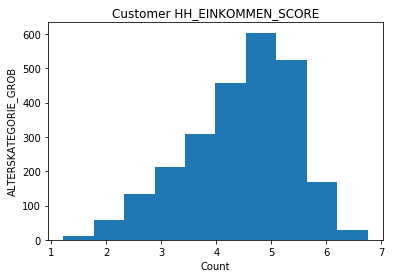

count    2510.000000
mean        4.446178
std         0.974533
min         1.214206
25%         3.853197
50%         4.606133
75%         5.172346
max         6.751822
Name: HH_EINKOMMEN_SCORE, dtype: float64


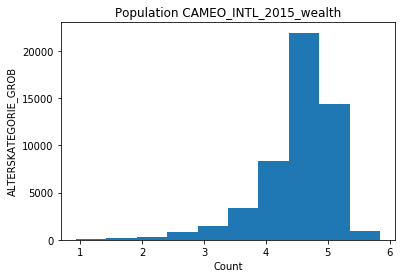

count    51866.000000
mean         4.521938
std          0.602793
min          0.929044
25%          4.311868
50%          4.653508
75%          4.909477
max          5.845812
Name: CAMEO_INTL_2015_wealth, dtype: float64


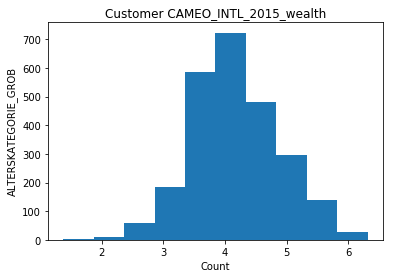

count    2510.000000
mean        4.170318
std         0.709743
min         1.374635
25%         3.700228
50%         4.112083
75%         4.649414
max         6.310828
Name: CAMEO_INTL_2015_wealth, dtype: float64


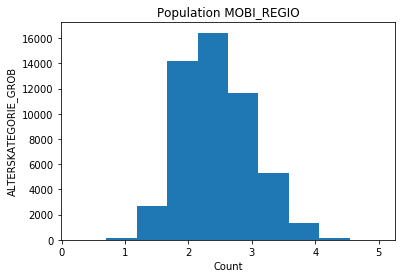

count    51866.000000
mean         2.447335
std          0.553543
min          0.225340
25%          2.030409
50%          2.393916
75%          2.818753
max          5.022536
Name: MOBI_REGIO, dtype: float64


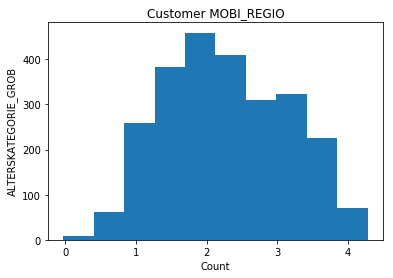

count    2510.000000
mean        2.280512
std         0.860300
min        -0.029696
25%         1.612465
50%         2.214522
75%         2.972380
max         4.280616
Name: MOBI_REGIO, dtype: float64


In [110]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Will examine cluster 17

columns = ['ALTERSKATEGORIE_GROB','ANREDE_KZ','HH_EINKOMMEN_SCORE','CAMEO_INTL_2015_wealth','MOBI_REGIO']
k = 17

demographics_comparison(k, columns)

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Cluster 3 contained a larger proportion of customers compared to the general population. This cluster tended to contain individuals of a lower age, more males than females, slightly wealthier individuals, and those showing more movement than the general population. Alternatively, cluster 17 contained a larger proportion of the general population compared to the current customer pool. This cluster tended to contain individuals in the population who were slightly older and less wealthy than customers, but overall the demogrpahic variables chosen where very similar across the general population and current customers. Overall, segments of the population that appear to be relatively popular with the mail order company appear to be slightly younger, wealthy, males.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.